In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.5])

In [8]:
additional_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.grouping_type.value != "sic_description":
        for member in Indicator:
            pm = copy.deepcopy(portfolio)
            pm.ranking_metric = member.label
            additional_portfolios.append(pm)

In [18]:
analysises = []
for rolling_window in [20,40,60,100]:
    market.connect()
    prices = []
    for ticker in tqdm(index["ticker"]): 
        try:
            price = market.query("prices", {"ticker": ticker})
            if price.index.size > 150:
                price = p.lower_column(price)
                price = p.utc_date(price)
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                for member in Metric:
                    price = member.calculate(price,timeframe=rolling_window)
                for member in Indicator:
                    price = member.calculate(price,timeframe=rolling_window)
                for member in RiskType:
                    price = member.apply(price)
                prices.append(price.dropna())
        except Exception as e:
            print(str(e))
            continue
    market.disconnect()
    model_end = 2015
    backtest_end = 2025
    simulation = pd.concat(prices)
    simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
    simulation.sort_values("date", inplace=True)
    for portfolio in tqdm(additional_portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

  1%|█▏                                                                                                                                                                                           | 26/4266 [00:01<04:57, 14.24it/s]


KeyboardInterrupt: 

In [19]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [20]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
52,52,ema,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,61610.731853,4.136064,14895.983022,1.106177,0.903688,0.565909,1.018278,4.135709,<financial_common.portfolio_management.portfol...,20
50,50,sma,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,60421.328033,4.567067,13229.786682,1.105104,0.904233,0.566455,1.018017,4.566671,<financial_common.portfolio_management.portfol...,20
18,18,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,7857.795634,3.489915,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,<financial_common.portfolio_management.portfol...,20
20,20,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,5218.902775,2.444101,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,<financial_common.portfolio_management.portfol...,20
23,23,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,3574.180285,3.851456,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,<financial_common.portfolio_management.portfol...,20
55,55,bollinger_upper,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,2862.931227,4.352098,657.827826,1.092225,0.920133,0.559091,1.016348,4.344125,<financial_common.portfolio_management.portfol...,20
116,116,ema,WEEK,long,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,0.5,2684.541369,3.668692,731.743550,1.087826,0.916482,0.553364,1.011298,3.661480,<financial_common.portfolio_management.portfol...,20
114,114,sma,WEEK,long,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,0.5,1133.919516,4.613672,245.773777,1.087787,0.917446,0.550545,1.011227,4.592202,<financial_common.portfolio_management.portfol...,20
42,42,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,1046.602981,3.310698,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,<financial_common.portfolio_management.portfol...,20
56,56,bollinger_lower,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,734.461348,2.249605,326.484548,1.077279,0.915936,0.562909,1.006758,2.233443,<financial_common.portfolio_management.portfol...,20


In [21]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

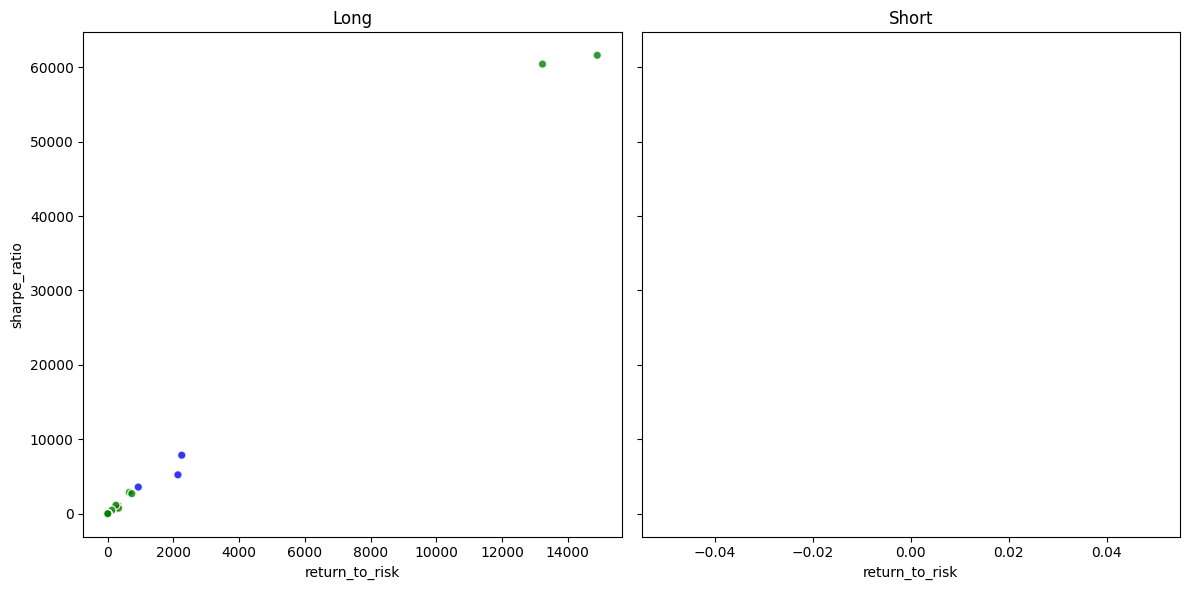

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [23]:
valid = a[(a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,...,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,color,return_to_risk
52,ema,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,61610.731853,...,14895.983022,1.106177,0.903688,0.565909,1.018278,4.135709,<financial_common.portfolio_management.portfol...,20,green,4.136064
50,sma,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,60421.328033,...,13229.786682,1.105104,0.904233,0.566455,1.018017,4.566671,<financial_common.portfolio_management.portfol...,20,green,4.567067
18,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,7857.795634,...,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,<financial_common.portfolio_management.portfol...,20,blue,3.489915
20,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,5218.902775,...,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,<financial_common.portfolio_management.portfol...,20,blue,2.444101
23,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3574.180285,...,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,<financial_common.portfolio_management.portfol...,20,blue,3.851456
55,bollinger_upper,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2862.931227,...,657.827826,1.092225,0.920133,0.559091,1.016348,4.344125,<financial_common.portfolio_management.portfol...,20,green,4.352098
116,ema,WEEK,long,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2684.541369,...,731.743550,1.087826,0.916482,0.553364,1.011298,3.661480,<financial_common.portfolio_management.portfol...,20,green,3.668692
114,sma,WEEK,long,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1133.919516,...,245.773777,1.087787,0.917446,0.550545,1.011227,4.592202,<financial_common.portfolio_management.portfol...,20,green,4.613672
42,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1046.602981,...,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,<financial_common.portfolio_management.portfol...,20,red,3.310698
56,bollinger_lower,WEEK,long,STANDARD_DEV,long_short,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,734.461348,...,326.484548,1.077279,0.915936,0.562909,1.006758,2.233443,<financial_common.portfolio_management.portfol...,20,green,2.249605


In [26]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=20)
            for member in Indicator:
                price = member.calculate(price,timeframe=20)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [03:56<00:00, 18.04it/s]


In [42]:
top = valid[valid["selection_type"]!="long_short"].sort_values("sharpe_ratio",ascending=False).head(20).to_dict("records")[0]
print(top)
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

{'ranking_metric': 'bollinger_upper', 'timeframe': 'WEEK', 'position_type': 'long', 'grouping_type': 'STANDARD_DEV', 'selection_type': 'top', 'allocation_type': 'equal', 'risk_type': 'coefficient_of_variation', 'selection_percentage': 0.5, 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'), 'pnl': 3574.180285447315, 'coefficient_of_variation': 3.8514557382289487, 'portfolio_std': 928.007623187918, 'average_gain': 1.107332336629192, 'average_loss': 0.9156628567932003, 'win_loss_ratio': 0.536, 'weekly_return': 1.0183976979852918, 'sharpe_ratio': 3.8458041777863445, 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio object at 0x00000206D2E7D9D0>, 'rolling_window': 20, 'color': 'blue', 'return_to_risk': 3.8514557382289487}


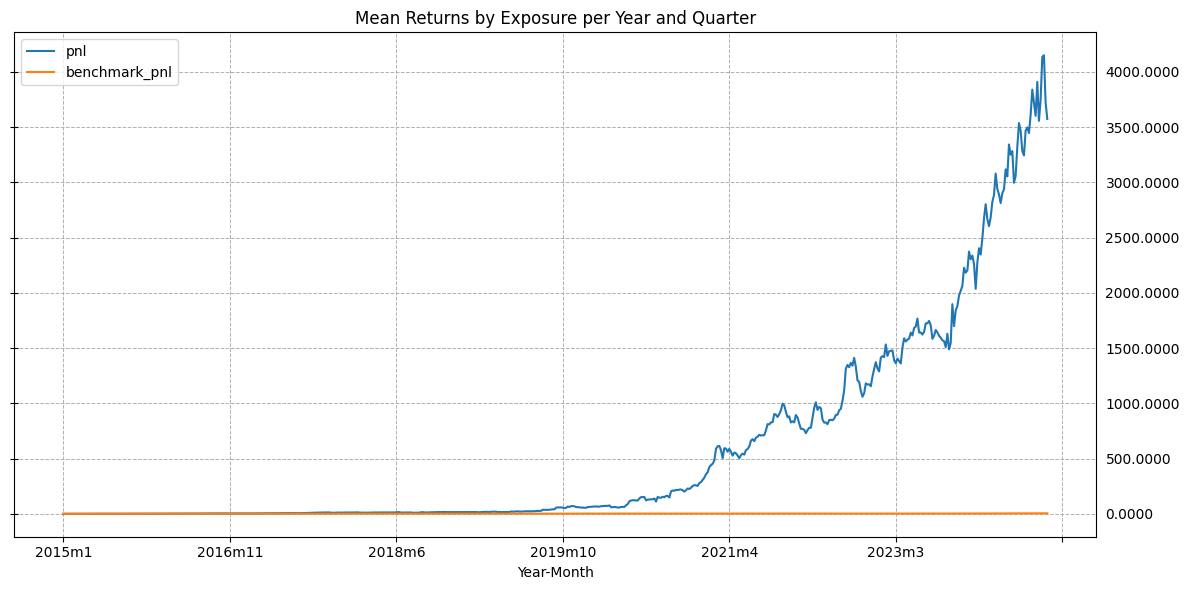

In [43]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [44]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
RITM,1.381517
PHAT,1.381517
PSNY,1.381517
RIGL,1.381517
PBM,1.381517
...,...
TCRT,0.800000
SOBR,0.800000
IHRT,0.800000


In [45]:
trades.sort_values("date",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,bollinger_upper,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,winsorized_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,
2024_51_0.9,2024,51,AQB,2024-12-20 00:00:00+00:00,0.5801,0.5240,0.126204,2.027537,0.198043,0.9,0.002,1.0,1,0.903293,0.903293,0.903293,12,4
2024_51_0.4,2024,51,PYXS,2024-12-20 00:00:00+00:00,1.6800,1.6900,0.943522,2.554657,0.227859,0.4,0.002,1.0,1,1.005952,1.005952,1.005952,12,4
2024_51_1.0,2024,51,FTFT,2024-12-20 00:00:00+00:00,0.2705,0.3014,0.054107,1.821229,0.135656,1.0,0.005,1.0,1,1.114233,1.114233,1.114233,12,4
2024_51_0.1,2024,51,APLT,2024-12-20 00:00:00+00:00,1.1500,0.8801,4.012239,11.254546,0.372333,0.1,0.002,1.0,1,0.800000,0.800000,0.800000,12,4
2024_51_0.2,2024,51,SGN,2024-12-20 00:00:00+00:00,3.3600,2.9100,1.962458,3.371940,0.345795,0.2,0.002,1.0,1,0.866071,0.866071,0.866071,12,4
2024_51_0.3,2024,51,RLMD,2024-12-20 00:00:00+00:00,0.3888,0.3629,1.239146,11.999816,0.298785,0.3,0.002,1.0,1,0.933385,0.933385,0.933385,12,4
2024_51_0.0,2024,51,DCTH,2024-12-20 00:00:00+00:00,12.2200,11.0100,10782.843936,1781.729903,0.000000,0.0,0.005,1.0,1,0.900982,0.900982,0.900982,12,4
2024_51_0.5,2024,51,PBM,2024-12-20 00:00:00+00:00,1.8500,3.1800,0.729945,2.407913,0.951031,0.5,0.002,1.0,1,1.381517,1.381517,1.381517,12,4
2024_51_0.6,2024,51,CLRB,2024-12-20 00:00:00+00:00,0.2577,0.2350,0.477635,8.831653,0.211915,0.6,0.002,1.0,1,0.911913,0.911913,0.911913,12,4
